In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate, RepeatedKFold, GridSearchCV
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from urbem.features.selection import KBestSelector

In [2]:
PATH_TO_PROCESSED_FILES = Path("../data/processed/")
ROME_GEOJSON = (
    PATH_TO_PROCESSED_FILES / "Rome_urban_zones_with_features_and_emissions__epsg4326.geojson"
)
PATH_TO_OUTPUT = Path("../reports/figures/")

SAVE_FIG = False
axis_label_fontsize=21
axis_ticklabel_fontsize=20

RANDOM_STATE = 4

# Cross Validation
N_SPLITS = 5
N_REPEATS = 5

In [3]:
np.random.seed(RANDOM_STATE)

## Loading the spatial tessellation

In [4]:
gdf_rome = gpd.read_file(ROME_GEOJSON)
print(gdf_rome.shape)

(155, 36)


Based on [Spatial Regression — Geographic Data Science with Python](https://geographicdata.science/book/notebooks/11_regression.html)

In [5]:
gdf_rome.drop(columns=["geometry",'area_code','SHAPE_Leng','SHAPE_Area']).head()

,area_name,n_traffic_lights,density_traffic_lights,n_shops,density_shops,street_len_tot,street_density,motorway_ratio,motorway_roads_density,trunk_roads_density,...,perc_people_close_to_public_transport,pop_density,avg_CO_2_per_road,CO_2_alpha,avg_NO_x_per_road,NO_x_alpha,avg_PM_per_road,PM_alpha,avg_VOC_per_road,VOC_alpha
0,Morena,10.0,1.117665,960,107.295822,90462.509,10.110676,0.000000,0.000000,0.0,...,2.8,36.9,45.691790,1.379673,0.028145,1.379998,0.000711,1.372780,0.135578,1.360149
1,Don Bosco,17.0,7.534299,1854,821.681815,40177.642,17.806493,0.000000,0.000000,0.0,...,93.6,225.9,19.736626,1.506453,0.024918,1.753734,0.000606,1.675556,0.078710,1.261183
2,Appio-Claudio,16.0,4.631520,1236,357.784910,34284.729,9.924400,0.000000,0.000000,0.0,...,99.8,86.1,17.311154,1.406042,0.013976,1.272973,0.000557,1.558339,0.067396,1.041726
3,Quarto Miglio,9.0,1.789208,738,146.715093,50001.583,9.940362,0.203666,1.306387,0.0,...,35.1,21.7,297.379845,1.387901,0.107992,1.418191,0.001484,1.267525,0.525855,1.523452
4,Pignatelli,2.0,2.005417,178,178.482157,11279.941,11.310495,0.000000,0.000000,0.0,...,0.0,66.3,33.474434,1.065894,0.023046,1.000000,0.000804,1.221868,0.103474,1.000000


In [6]:
feature_to_predict = "avg_CO_2_per_road"

all_predictors = [
    'n_traffic_lights', 'density_traffic_lights', 
    'n_shops', 'density_shops', 
    'street_len_tot', 'street_density', #'motorway_ratio',
    'motorway_roads_density', 'trunk_roads_density',
    'primary_roads_density', 'all_heavy_roads_density',
    'n_food_amenities', 'density_food_amenities', 
    'n_education_amenities', 'density_education_amenities', 
    'n_service_amenities', 'density_service_amenities', 
    'n_all_amenities', 'density_all_amenities',
    'perc_roads_bc', 'car_accidents',
    'perc_people_close_to_public_transport', 'pop_density',
]

## Linear regression

Based on [Urbana - Urban Data Analysis](https://github.com/egregorimar/urbana)

In [7]:
dependent_variable = feature_to_predict
independent_variables = all_predictors

In [8]:
gdf_rome_connected = gdf_rome.drop(index=[97])

#### Checking multicollinearity

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

variables_to_check = [
    'density_traffic_lights',
    #'density_shops',
    #'street_len_tot',
    'street_density',
    #'motorway_ratio',
    'motorway_roads_density', 
    'trunk_roads_density',
    'primary_roads_density', 
    #'all_heavy_roads_density',
    #'density_food_amenities',
    #'density_education_amenities',
    #'density_service_amenities',
    'density_all_amenities',
    'perc_roads_bc',
    'car_accidents',
    'perc_people_close_to_public_transport',
    'pop_density'
]

features = "+".join(variables_to_check)
y_vif, X_vif = dmatrices('avg_CO_2_per_road ~' + features, gdf_rome_connected[[dependent_variable]+variables_to_check], return_type='dataframe')

###Calculate VIF Factors
vif=pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_vif.values,i) for i in range(X_vif.shape[1])]
vif["features"] = X_vif.columns

print(vif.round(1))

    VIF Factor                               features
0         11.0                              Intercept
1          3.0                 density_traffic_lights
2          3.5                         street_density
3          1.2                 motorway_roads_density
4          1.1                    trunk_roads_density
5          1.2                  primary_roads_density
6          2.2                  density_all_amenities
7          1.2                          perc_roads_bc
8          1.4                          car_accidents
9          1.8  perc_people_close_to_public_transport
10         2.5                            pop_density


In [10]:
non_correlated_features = vif.loc[vif['VIF Factor'] <= 5, 'features'].to_list()
non_correlated_features

['density_traffic_lights',
 'street_density',
 'motorway_roads_density',
 'trunk_roads_density',
 'primary_roads_density',
 'density_all_amenities',
 'perc_roads_bc',
 'car_accidents',
 'perc_people_close_to_public_transport',
 'pop_density']

#### Variables transformation
We apply a Yeo-Johnson transform to the $y$ in order to make its distribution more Gaussian-like.

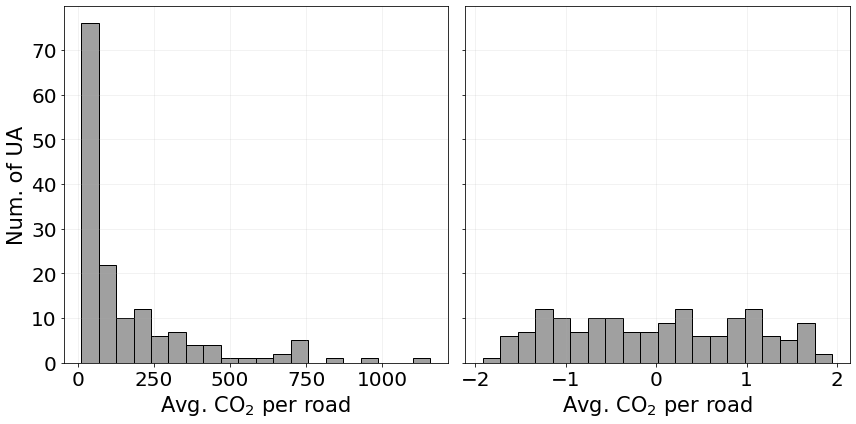

In [11]:
y = gdf_rome_connected[feature_to_predict]

## y
pwt = PowerTransformer()
pwt.fit(y.values.reshape(-1, 1))

y_transformed = pd.Series(pwt.transform(y.values.reshape(-1, 1)).flatten())
y_transformed.name = "Transformed avg CO2 per road"

fig, ax = plt.subplots(1,2, figsize=(12,6), sharey=True)

#ax[0].hist(y, bins=50, color='black')
sns.histplot(y, color="gray", kde=False, bins=20, ax=ax[0])
#ax[0].set_title('before transformation', fontsize=15)
ax[0].set_xlabel(r'Avg. CO$_2$ per road', fontsize=axis_label_fontsize)
ax[0].set_ylabel('Num. of UA', fontsize=axis_label_fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
ax[0].grid(alpha=0.2)

#ax[1].hist(y_transformed, bins=50, color='black')
sns.histplot(y_transformed, color="gray", kde=False,bins=20, ax=ax[1])
#ax[1].set_title(r'after transformation', fontsize=15)
ax[1].set_xlabel(r'Avg. CO$_2$ per road', fontsize=axis_label_fontsize)
ax[1].set_ylabel('Num. of UA', fontsize=axis_label_fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
ax[1].grid(alpha=0.2)

plt.tight_layout()
#plt.subplots_adjust(wspace=0.3)

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'hist_y_co2_transformation.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'hist_y_co2_transformation.png', format='png', dpi=300)

plt.show()

Let's see what happens if we apply the same transform to the $X$...

In [12]:
## X

POWER_TRANSFORM = False

X = gdf_rome_connected[non_correlated_features]

if POWER_TRANSFORM:
    pwt = PowerTransformer()
    pwt.fit(X)
    X_transformed = pd.DataFrame(pwt.transform(X), columns=X.columns)
else:
    ss = StandardScaler()
    ss.fit(X)
    X_transformed = pd.DataFrame(ss.transform(X), columns=X.columns)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def corrfunc(x, y, **kwds):
    cmap = kwds["cmap"]
    norm = kwds["norm"]
    ax = plt.gca()
    ax.tick_params(bottom=False, top=False, left=False, right=False)
    sns.despine(ax=ax, bottom=True, top=True, left=True, right=True)
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    ax.set_facecolor(facecolor)
    lightness = (max(facecolor[:3]) + min(facecolor[:3])) / 2
    ax.annotate(
        f"r={r:.2f}",
        xy=(0.5, 0.5),
        xycoords=ax.transAxes,
        color="white" if lightness < 0.7 else "black",
        size=35,
        ha="center",
        va="center",
    )

def scattfunc(x, y, **kwds):
    cmap = kwds["cmap"]
    norm = kwds["norm"]
    ax = plt.gca()
    r, _ = pearsonr(x, y)
    facecolor = cmap(norm(r))
    lightness = (max(facecolor[:3]) + min(facecolor[:3])) / 2
    myColor = "white" if lightness < 0.7 else "black"
    lineColor = "black" if lightness < 0.7 else "white"
    ax.set_facecolor(facecolor)
    sns.regplot(x, y, ax=ax, color=myColor, line_kws={"color": lineColor}, ci=None)

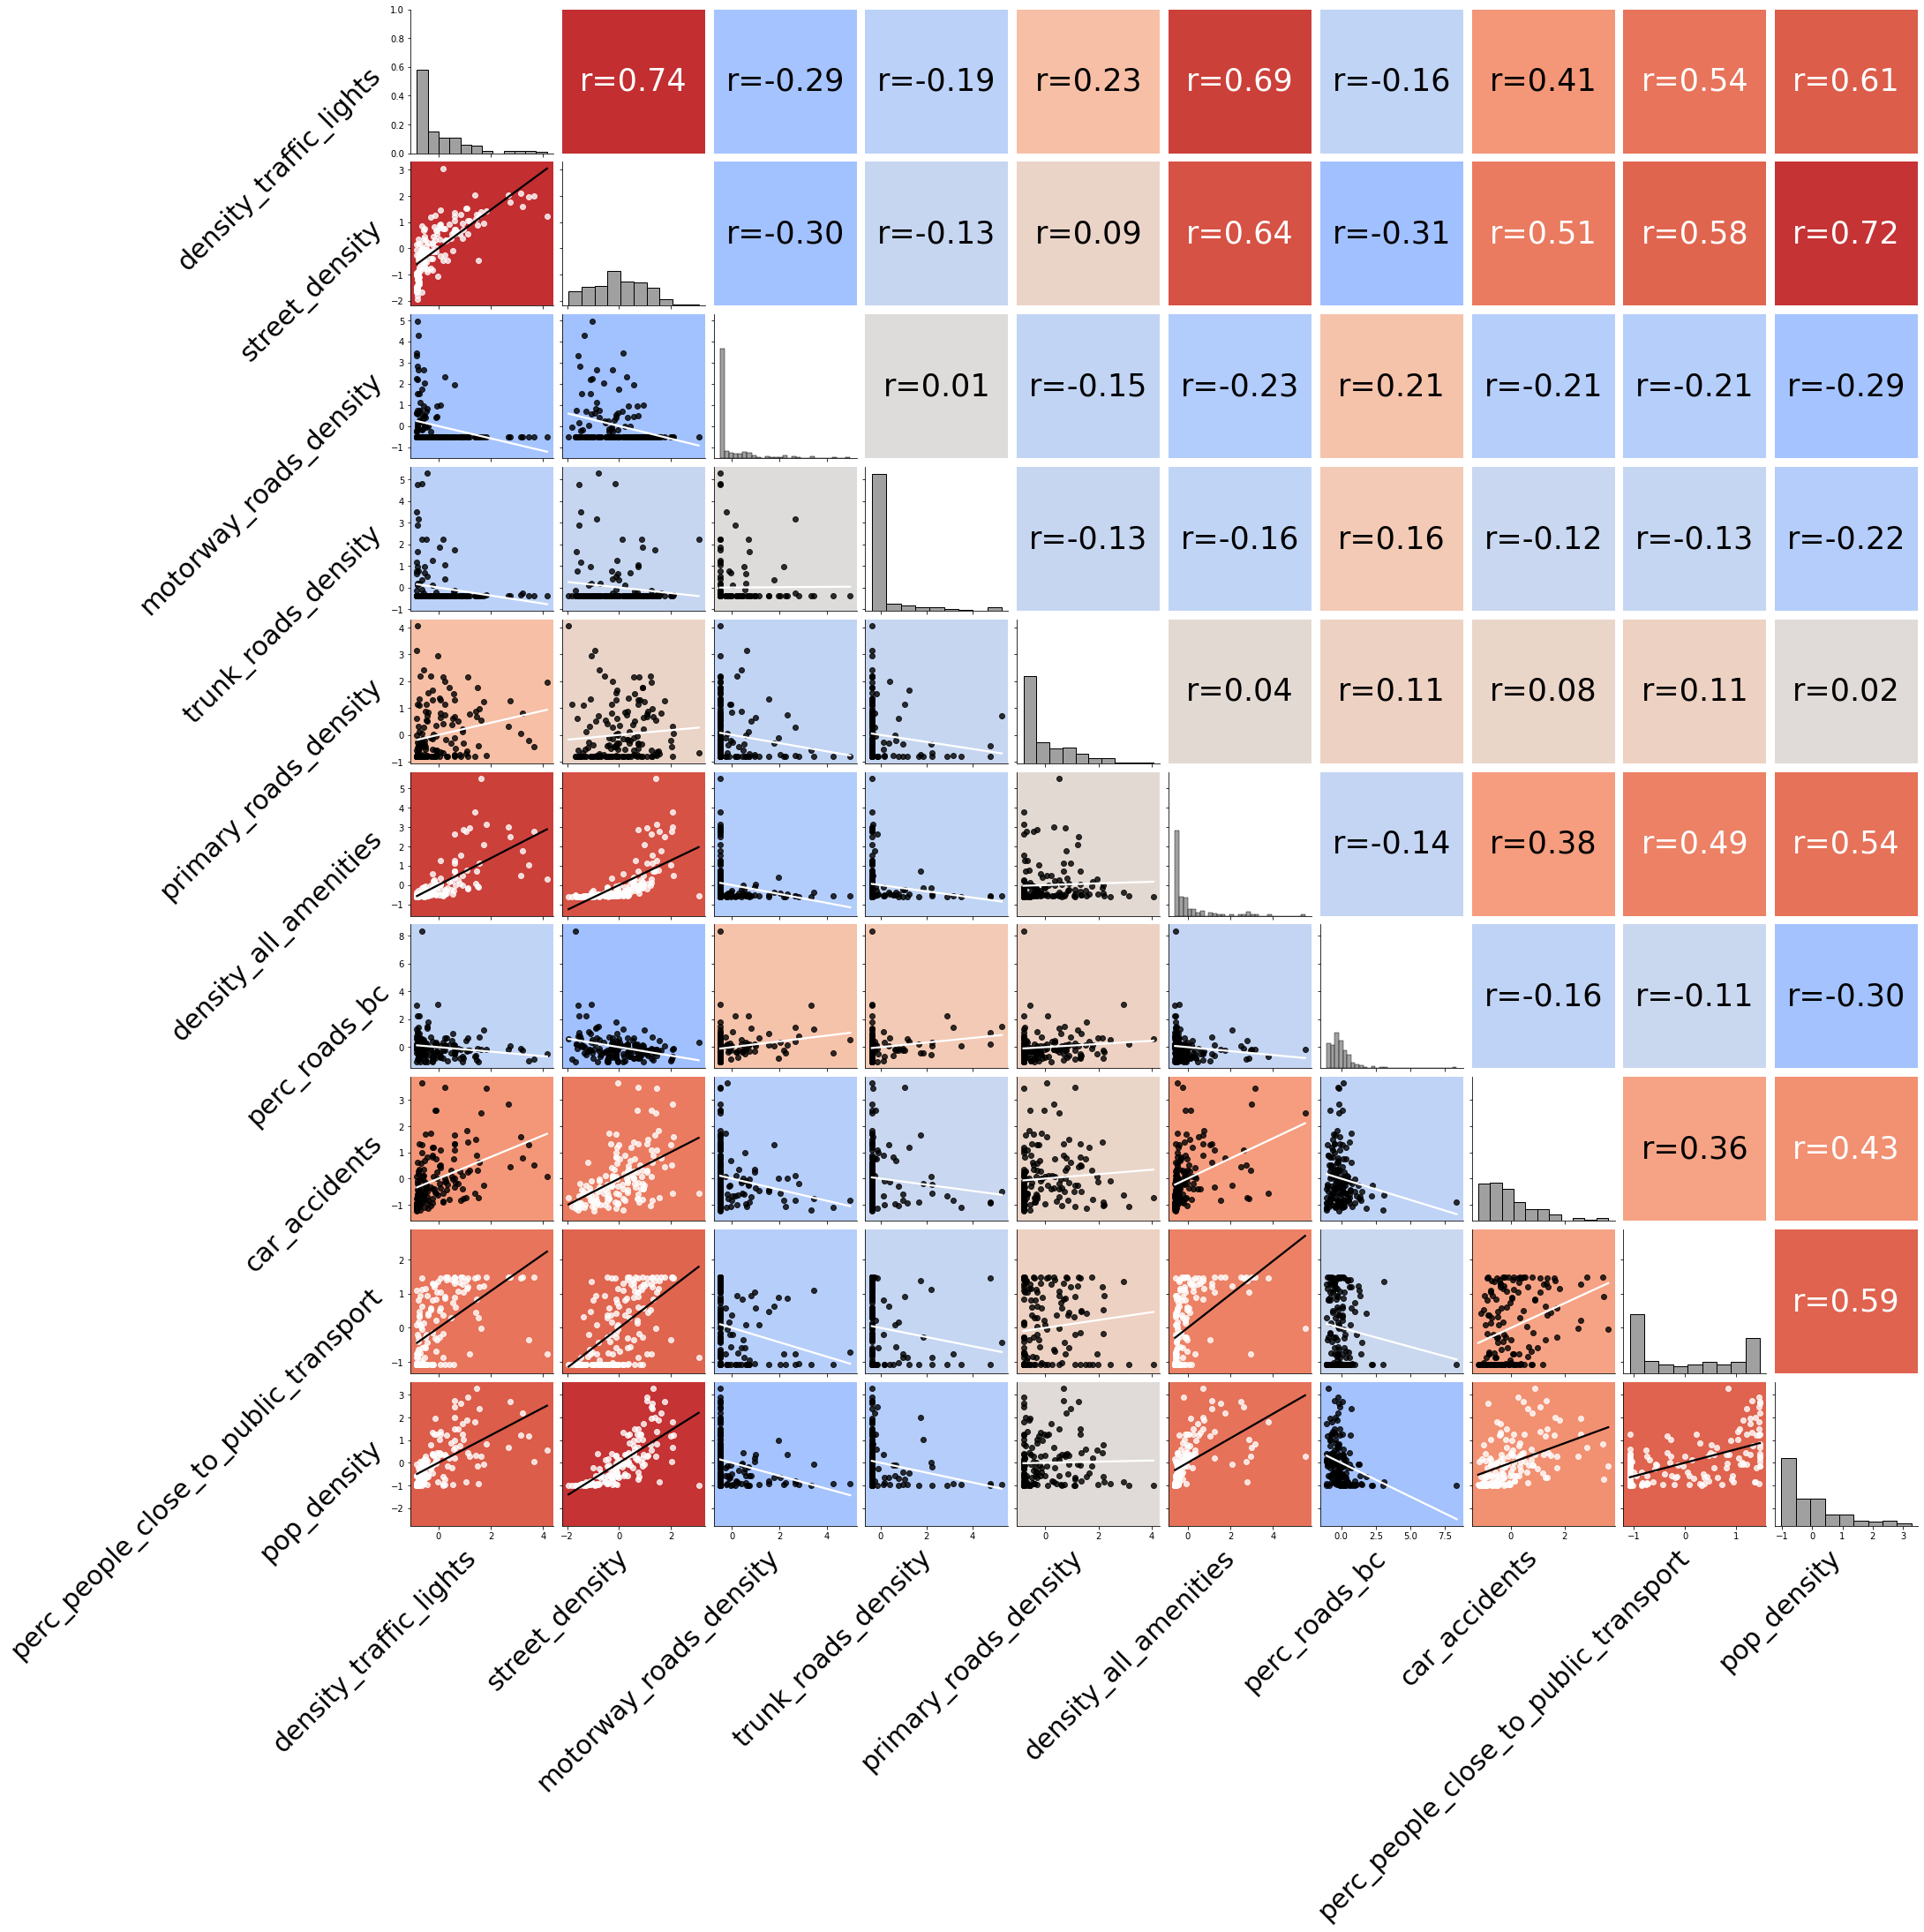

In [29]:
import warnings
warnings.filterwarnings('ignore')

# plotting PairGrid
f = sns.PairGrid(X_transformed)
f.map_lower(scattfunc, cmap=plt.get_cmap("coolwarm"), norm=plt.Normalize(vmin=-0.8, vmax=0.8))
f.map_diag(sns.histplot, color="gray", kde=False)
f.map_upper(corrfunc, cmap=plt.get_cmap("coolwarm"), norm=plt.Normalize(vmin=-0.8, vmax=0.8))
f.fig.subplots_adjust(wspace=0.06, hspace=0.06)  # equal spacing in both directions
for ax in plt.gcf().axes:
    xlabel = ax.get_xlabel()
    ax.set_xlabel(xlabel, fontsize=30, rotation=45, ha="right")
    ylabel = ax.get_ylabel()
    ax.set_ylabel(ylabel, fontsize=30, rotation=45, ha="right")

#plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'features_correlations.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(PATH_TO_OUTPUT / 'features_correlations.png', format='png', bbox_inches='tight', dpi=300)

If we apply the Yeo-Johnson transform also to the predictors, we obtain more correlated features. Thus, we will only scale these features.

## Linear regression

### First model with fixed set of (uncorrelated) features

In [14]:
X = gdf_rome_connected[non_correlated_features]
y = gdf_rome_connected[feature_to_predict]

In [15]:
preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

pipe_all = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

model_fixed = TransformedTargetRegressor(regressor=pipe_all, transformer=PowerTransformer())
model_fixed.fit(X, y)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('scaler',
                                                                       StandardScaler())])),
                                                     ('regressor',
                                                      LinearRegression())]),
                           transformer=PowerTransformer())

/tmp/ipykernel_21761/2608493936.py:21: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  medians_all = medians_all.append(pd.Series({"Intercept": 0}, index=["Intercept"]))


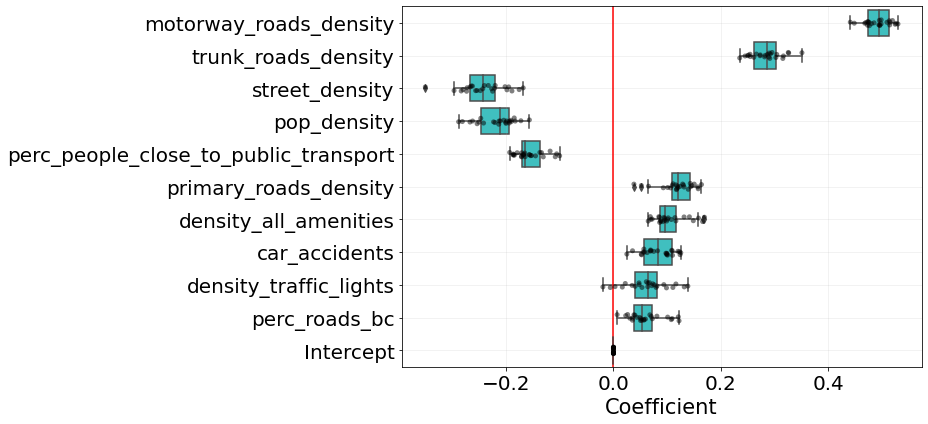

In [17]:
cv_all = cross_validate(
    model_fixed,
    X,
    y,
    cv=RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE),
    return_estimator=True,
    n_jobs=-1,
)

coefs_all = pd.DataFrame(
    [est.regressor_.named_steps["regressor"].coef_ for est in cv_all["estimator"]],
    columns=X.columns,
)

coefs_all["Intercept"] = pd.Series(
    [est.regressor_.named_steps["regressor"].intercept_ for est in cv_all["estimator"]]
)

medians_all = coefs_all.drop(["Intercept"], axis=1).median()
medians_all = medians_all.reindex(medians_all.abs().sort_values(ascending=False).index)
medians_all = medians_all.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
coefs_all = coefs_all[medians_all.index]


fig, ax = plt.subplots(figsize=(13, 6))
#plt.figure(figsize=(20, 1*len(independent_variables)))
sns.stripplot(data=coefs_all, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_all, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color="red")
ax.tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
ax.set_xlabel("Coefficient", fontsize=axis_label_fontsize)
ax.grid(alpha=0.2)
#plt.title(f"Sensitivity Analysis. \n Coefficients of the regression model with uncorrelated features", fontsize=15)
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'sensitivity_nonspatial_regression.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'sensitivity_nonspatial_regression.png', format='png', dpi=300)

plt.show()

> regression results <
Mean squared error: 0.35
Root mean squared error: 0.59
Median absolute error: 0.42
Coefficient of determination: 0.65



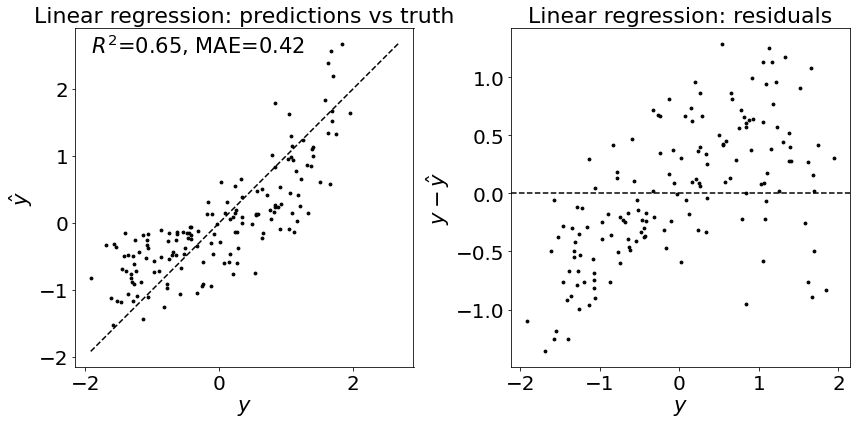

In [16]:
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

# predicting and computing residuals
y_pred = model_fixed.predict(X)#.round()
res = [y.iloc[i]-y_pred[i] for i in range(len(y))]


pwt = PowerTransformer()
pwt.fit(y.values.reshape(-1, 1))

# re-transform y_pred
y_pred_transformed = pwt.transform(y_pred.reshape(-1, 1)).flatten()

# re-transform y
y_transformed = pwt.transform(y.values.reshape(-1, 1)).flatten()

res_transformed = [y_transformed[i]-y_pred_transformed[i] for i in range(len(y_transformed))]

print('> regression results <')
#print("Coefficients: \n", model.coef_)
#print("Intercept: ", model.intercept_)
mse = mean_squared_error(y_transformed, y_pred_transformed)
rmse = mean_squared_error(y_transformed, y_pred_transformed, squared=False)
mae = median_absolute_error(y_transformed, y_pred_transformed)
r2 = r2_score(y_transformed, y_pred_transformed)
print("Mean squared error: %.2f" % mse)
print("Root mean squared error: %.2f" % rmse)
print("Median absolute error: %.2f" % mae)
print("Coefficient of determination: %.2f" % r2)
print('')

# plotting the results
f, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].scatter(y_transformed, y_pred_transformed, color='black', s=8)
p1 = max(max(y_pred_transformed), max(y_transformed))
p2 = min(min(y_pred_transformed), min(y_transformed))
axs[0].plot([p1, p2], [p1, p2], '--k')
axs[0].set_ylabel(r'$\hat{y}$', fontsize=axis_label_fontsize)
axs[0].set_xlabel(r'$y$', fontsize=axis_label_fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
axs[0].set_title('Linear regression: predictions vs truth', fontsize=22)
axs[0].text(p2, max(y_pred_transformed)-(max(y_pred_transformed)/100*5), '$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_transformed, y_pred_transformed), median_absolute_error(y_transformed, y_pred_transformed)),
    fontdict={'size':axis_label_fontsize})
axs[1].scatter(y_transformed, res_transformed, color='black', s=8)
axs[1].axhline(0, linestyle='--', color='black')
axs[1].set_ylabel(r'$y-\hat{y}$', fontsize=axis_label_fontsize)
axs[1].set_xlabel(r'$y$', fontsize=axis_label_fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=axis_ticklabel_fontsize)
axs[1].set_title('Linear regression: residuals', fontsize=22)
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'predictions_nonspatial_regression.pdf', format='pdf')
    plt.savefig(PATH_TO_OUTPUT / 'predictions_nonspatial_regression.png', format='png', dpi=300)

Moran's I:  0.16838019944781135 0.002


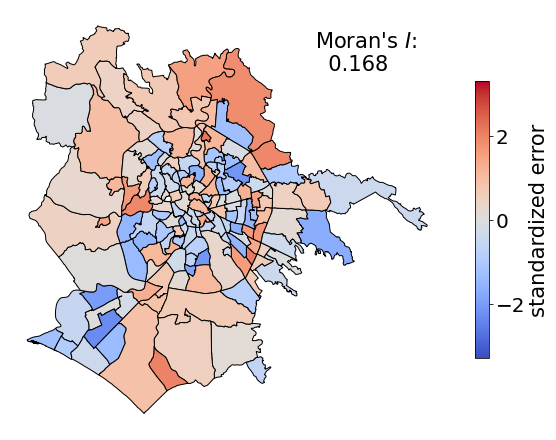

In [25]:
### model's error to plot:

# scaled residuals
#error_to_plot = res_scaled   # (res - mean(res)) / std(res)

# standardized residuals
error_to_plot = (y_transformed - y_pred_transformed) / np.std(y_transformed - y_pred_transformed)

# SMAPE ? --> error_to_plot
#error_to_plot = 2 * (y_transformed - y_pred_transformed) / (abs(y_transformed) + abs(y_pred_transformed))

gdf_rome_connected["Chosen_Error"] = error_to_plot

## Global Moran's I
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import plot_moran

w = weights.Rook.from_dataframe(gdf_rome_connected)
w.transform = 'R'
assert w.n_components == 1
moran = esda.moran.Moran(gdf_rome_connected["Chosen_Error"], w)
print("Moran's I: ", moran.I, moran.p_sim)
##

col_lim = max(abs(gdf_rome_connected["Chosen_Error"].min()), abs(gdf_rome_connected["Chosen_Error"].max()))
#print(col_lim)

fig, ax = plt.subplots(figsize=(8, 8))

gdf_rome_connected.plot(
    ax=ax,
    column="Chosen_Error",
    legend=True,
    #figsize=(12, 12),
    edgecolor="black",
    cmap="coolwarm",
    vmin=-3.3, # setting max and min of colorbar so that the scale is the same for all the models (RF and GWR)
    vmax=3.3,
    legend_kwds={"shrink": 0.5},
)
cbar = ax.get_figure().get_axes()[1]
cbar.tick_params(labelsize=axis_ticklabel_fontsize)
cbar.set_ylabel('standardized error', fontsize=axis_label_fontsize)

ax.text(0.7, 0.85, "Moran's $I$: \n  %.3f" %moran.I, fontdict={'size':axis_label_fontsize}, transform=ax.transAxes)

#ax.set_title("Relative errors in linear model", fontsize=20, y=1.01)
ax.set_axis_off()
plt.tight_layout()

if SAVE_FIG:
    plt.savefig(PATH_TO_OUTPUT / 'map_errors_nonspatial_regression.pdf', format='pdf', bbox_inches='tight')
    plt.savefig(PATH_TO_OUTPUT / 'map_errors_nonspatial_regression.png', format='png', bbox_inches='tight', dpi=300)

plt.show()

In [60]:
## Global Moran's I
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import plot_moran

# spatial weights
w = weights.Rook.from_dataframe(gdf_rome_connected)
w.transform = 'R'
assert w.n_components == 1

# 
moran = esda.moran.Moran(gdf_rome_connected["Chosen_Error"], w)
moran.I, moran.p_sim

(nan, 0.001)

In [24]:
w.n
w.pct_nonzero

3.415415753078091

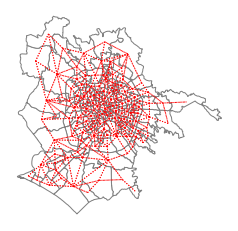

In [32]:
gdf_plot = gdf_rome_connected.reset_index()

ax = gdf_plot.plot(edgecolor='grey', facecolor='w')
f,ax = w.plot(gdf_plot, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

### Second model with feature selection

In [48]:
X = gdf_rome_connected[independent_variables]
y = gdf_rome_connected[dependent_variable]

print(independent_variables)

['n_traffic_lights', 'density_traffic_lights', 'n_shops', 'density_shops', 'street_len_tot', 'street_density', 'motorway_roads_density', 'trunk_roads_density', 'primary_roads_density', 'all_heavy_roads_density', 'n_food_amenities', 'density_food_amenities', 'n_education_amenities', 'density_education_amenities', 'n_service_amenities', 'density_service_amenities', 'n_all_amenities', 'density_all_amenities', 'perc_roads_bc', 'car_accidents', 'perc_people_far_from_public_transport', 'pop_density']


#### Feature Selection by Subgroups

In [49]:
POI_feat = [
    'density_shops', 
    'density_food_amenities',
    'density_education_amenities', 
    'density_service_amenities', 
    'density_all_amenities'
]
roads_feat = [
    'density_traffic_lights',
    'street_len_tot', 
    'street_density', 
    #'motorway_ratio',
    'motorway_roads_density', 
    'trunk_roads_density', 
    'primary_roads_density', 
    'all_heavy_roads_density'
    'perc_roads_bc',
    'car_accidents'
]
people_feat = [
    'perc_people_close_to_public_transport', 
    'pop_density'
]

In [50]:
preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

selector = KBestSelector(score_func=f_regression, preprocessor=preprocessor, power_transformer=PowerTransformer(), y=y)

In [51]:
## creating thematic sub-dataframes of the entire dataset

X_POI = gdf_rome_connected.filter(items=POI_feat, axis=1)
X_roads = gdf_rome_connected.filter(items=roads_feat, axis=1)
X_people = gdf_rome_connected.filter(items=people_feat, axis=1)

In [52]:
## selecting subsets of best K features from each sub-dataframe

# num. of features to select for each subset
k_POI = 1
k_roads = 3
k_people = 1

X_POI_chosen = selector.k_best_selection(features = X_POI, k = k_POI)
X_roads_chosen = selector.k_best_selection(features = X_roads, k = k_roads)
X_people_chosen = selector.k_best_selection(features = X_people, k = k_people)

In [53]:
list_k_best = X_POI_chosen.to_list() + X_roads_chosen.to_list() + X_people_chosen.to_list()

X_feat_subgroup = X[list_k_best]
X_feat_subgroup.columns

Index(['density_service_amenities', 'density_traffic_lights', 'street_density',
       'motorway_roads_density', 'pop_density'],
      dtype='object')

In [54]:
preprocessor = Pipeline(steps=[("scaler", StandardScaler())])

pipe_subgroup = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", LinearRegression()),
    ]
)

model_feat_subgroup = TransformedTargetRegressor(regressor=pipe_subgroup, transformer=PowerTransformer())
model_feat_subgroup.fit(X_feat_subgroup, y)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      Pipeline(steps=[('scaler',
                                                                       StandardScaler())])),
                                                     ('regressor',
                                                      LinearRegression())]),
                           transformer=PowerTransformer())

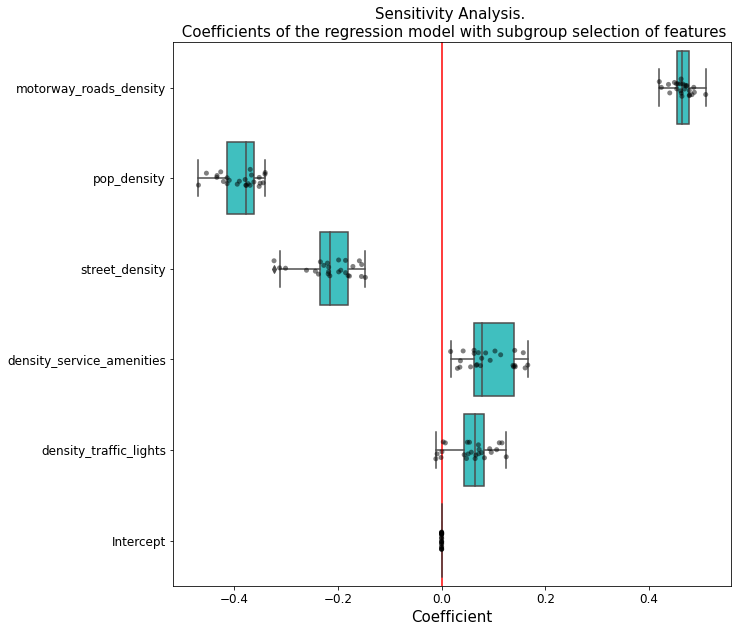

In [55]:
cv_feat_subgroup = cross_validate(
    model_feat_subgroup,
    X_feat_subgroup,
    y,
    cv=RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE),
    return_estimator=True,
    n_jobs=-1,
)

coefs_feat_subgroup = pd.DataFrame(
    [est.regressor_.named_steps["regressor"].coef_ for est in cv_feat_subgroup["estimator"]],
    columns=X_feat_subgroup.columns,
)

coefs_feat_subgroup["Intercept"] = pd.Series(
    [est.regressor_.named_steps["regressor"].intercept_ for est in cv_feat_subgroup["estimator"]]
)

medians_feat_subgroup = coefs_feat_subgroup.drop(["Intercept"], axis=1).median()
medians_feat_subgroup = medians_feat_subgroup.reindex(medians_feat_subgroup.abs().sort_values(ascending=False).index)
medians_feat_subgroup = medians_feat_subgroup.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
coefs_feat_subgroup = coefs_feat_subgroup[medians_feat_subgroup.index]


fig, ax = plt.subplots(figsize=(10, 10))
#plt.figure(figsize=(20, 1*len(independent_variables)))
sns.stripplot(data=coefs_feat_subgroup, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs_feat_subgroup, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color="red")
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Coefficient", fontsize=15)
plt.title(f"Sensitivity Analysis. \n Coefficients of the regression model with subgroup selection of features", fontsize=15)

plt.show()

#### Recursive Feature Elimination (RFE)
1. transform features (PowerTransformer)
2. RFE: tuning the number of features $N$ with a grid search cross validation using RMSE as evaluation metric

In [56]:
# Define a pipeline with the preprocessing, feature selection (RFE) and regressor

#preprocessor = Pipeline(steps=[("pt", PowerTransformer(standardize=True))])
preprocessor = Pipeline(steps=[("ss", StandardScaler())])


pipe_rfe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rfe", RFE(estimator=LinearRegression())),
        ("regressor", LinearRegression()),
    ]
)

# Define the param space for hyper-parameter tunning (in this case, the number of features to keep with RFE)
param_grid_rfe = [{"rfe__n_features_to_select": np.arange(1, len(all_predictors)+1, 1)}] # try with all the possible number of features

search_rfe = GridSearchCV(
    pipe_rfe, param_grid_rfe, scoring="neg_root_mean_squared_error", n_jobs=-1
)

model = TransformedTargetRegressor(regressor=search_rfe, transformer=PowerTransformer())
model.fit(X, y)


print("Best Model:")
print(
    "Number of features: "
    + str(model.regressor_.best_params_["rfe__n_features_to_select"])
)
print("\nList of features:")
cols_rfe = model.regressor_.best_estimator_.named_steps["rfe"].get_support(indices=True)
print(X.columns[cols_rfe])

Best Model:
Number of features: 9

List of features:
Index(['n_shops', 'density_shops', 'street_density', 'motorway_roads_density',
       'trunk_roads_density', 'n_food_amenities', 'density_food_amenities',
       'n_all_amenities', 'pop_density'],
      dtype='object')


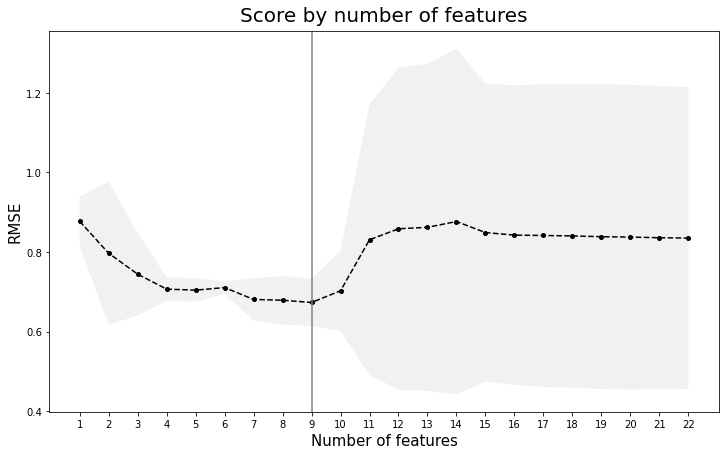

In [57]:
score_features = -model.regressor_.cv_results_["mean_test_score"]
score_std_features = model.regressor_.cv_results_["std_test_score"]
n_features = []
for i in model.regressor_.cv_results_["params"]:
    n_features.append(i["rfe__n_features_to_select"])

id_min_score = score_features.argmin()

fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(n_features, score_features, marker=".", markersize=8, color='black', linestyle='--')
plt.axvline(x=n_features[id_min_score], color=".5")

ax.fill_between(n_features, score_features+score_std_features, score_features-score_std_features, 
                    alpha=0.3, facecolor='lightgrey')

ax.set_xlabel("Number of features", fontsize=15)
ax.set_ylabel("RMSE", fontsize=15)
ax.set_xticks(np.arange(min(n_features), max(n_features) + 1))
ax.set_title("Score by number of features", fontsize=20, y=1.01)

plt.show()

In [19]:
model.regressor_.scorer_

make_scorer(mean_squared_error, greater_is_better=False, squared=False)

> regression results <
Mean squared error: 0.36
Root mean squared error: 0.60
Median absolute error: 0.37
Coefficient of determination: 0.64



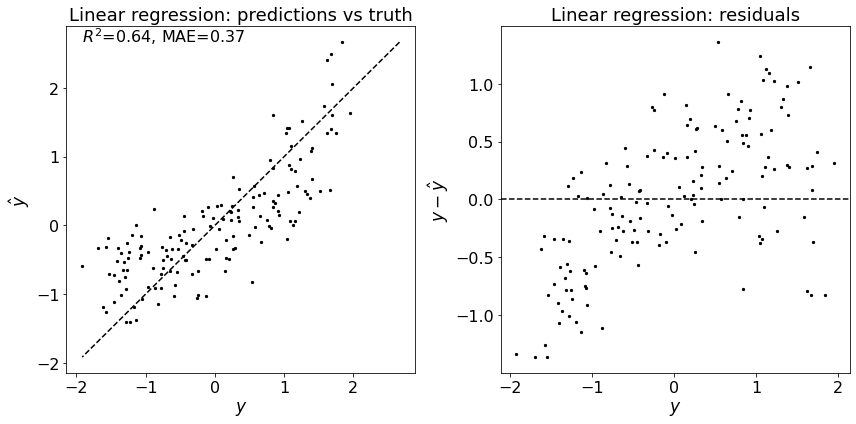

In [58]:
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

# predicting and computing residuals
y_pred_rfe = model.predict(X)#.round()
res = [y.iloc[i]-y_pred_rfe[i] for i in range(len(y))]


pwt = PowerTransformer()
pwt.fit(y.values.reshape(-1, 1))

# re-transform y_pred
y_pred_transformed = pwt.transform(y_pred_rfe.reshape(-1, 1)).flatten()

# re-transform y
y_transformed = pd.Series(pwt.transform(y.values.reshape(-1, 1)).flatten())
y_transformed.name = "Transformed avg CO2 per road"

res_transformed = [y_transformed.iloc[i]-y_pred_transformed[i] for i in range(len(y_transformed))]

print('> regression results <')
#print("Coefficients: \n", model.coef_)
#print("Intercept: ", model.intercept_)
mse = mean_squared_error(y_transformed, y_pred_transformed)
rmse = mean_squared_error(y_transformed, y_pred_transformed, squared=False)
mae = median_absolute_error(y_transformed, y_pred_transformed)
r2 = r2_score(y_transformed, y_pred_transformed)
print("Mean squared error: %.2f" % mse)
print("Root mean squared error: %.2f" % rmse)
print("Median absolute error: %.2f" % mae)
print("Coefficient of determination: %.2f" % r2)
print('')

# plotting the results
f, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].scatter(y_transformed, y_pred_transformed, color='black', s=5)
p1 = max(max(y_pred_transformed), max(y_transformed))
p2 = min(min(y_pred_transformed), min(y_transformed))
axs[0].plot([p1, p2], [p1, p2], '--k')
axs[0].set_ylabel(r'$\hat{y}$', fontsize=17)
axs[0].set_xlabel(r'$y$', fontsize=17)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].set_title('Linear regression: predictions vs truth', fontsize=18)
axs[0].text(p2, max(y_pred_transformed), r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_transformed, y_pred_transformed), median_absolute_error(y_transformed, y_pred_transformed)),
    fontdict={'size':16})
axs[1].scatter(y_transformed, res_transformed, color='black', s=5)
axs[1].axhline(0, linestyle='--', color='black')
axs[1].set_ylabel(r'$y-\hat{y}$', fontsize=17)
axs[1].set_xlabel(r'$y$', fontsize=17)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[1].set_title('Linear regression: residuals', fontsize=18)
plt.tight_layout()

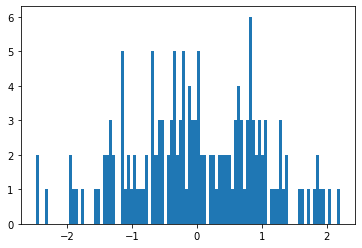

In [36]:
scaler = StandardScaler()
res_scaled = scaler.fit_transform(np.array(res_transformed).reshape(-1,1))

plt.hist(res_scaled, bins=100)
plt.show()

In [37]:
print('Mean of residuals: ', np.mean(res_transformed))
print('Mean of scaled residuals: ', np.mean(res_scaled))

Mean of residuals:  3.0999733804468655e-17
Mean of scaled residuals:  -1.4418480839287748e-18


#### Autocorrelation of the model's residuals
If the errors of the model (the residuals) are related systematically among themselves, i.e. we can observe autocorrelation between them, then we have a problem and need to use a more appropriate approach: a spatial regression model.

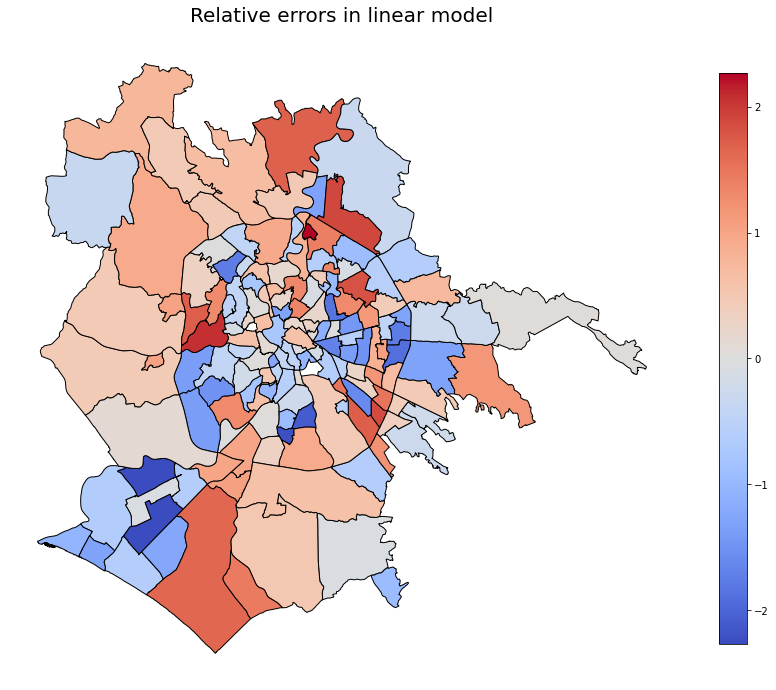

In [59]:
### model's error to plot:

# scaled residuals
#error_to_plot = res_scaled   # (res - mean(res)) / std(res)

# standardized residuals
error_to_plot = (y_transformed - y_pred_transformed) / np.std(y_transformed - y_pred_transformed)

# SMAPE ? --> error_to_plot
#error_to_plot = 2 * (y_transformed - y_pred_transformed) / (abs(y_transformed) + abs(y_pred_transformed))


gdf_rome_connected["Chosen_Error"] = error_to_plot

col_lim = max(abs(gdf_rome_connected["Chosen_Error"].min()), abs(gdf_rome_connected["Chosen_Error"].max()))

fig, ax = plt.subplots(figsize=(15, 15))

gdf_rome_connected.plot(
    ax=ax,
    column="Chosen_Error",
    legend=True,
    figsize=(15, 15),
    edgecolor="black",
    cmap="coolwarm",
    vmin=-col_lim,
    vmax=col_lim,
    legend_kwds={"shrink": 0.7},
)

ax.set_title("Relative errors in linear model", fontsize=20, y=1.01)
ax.set_axis_off()

plt.show()

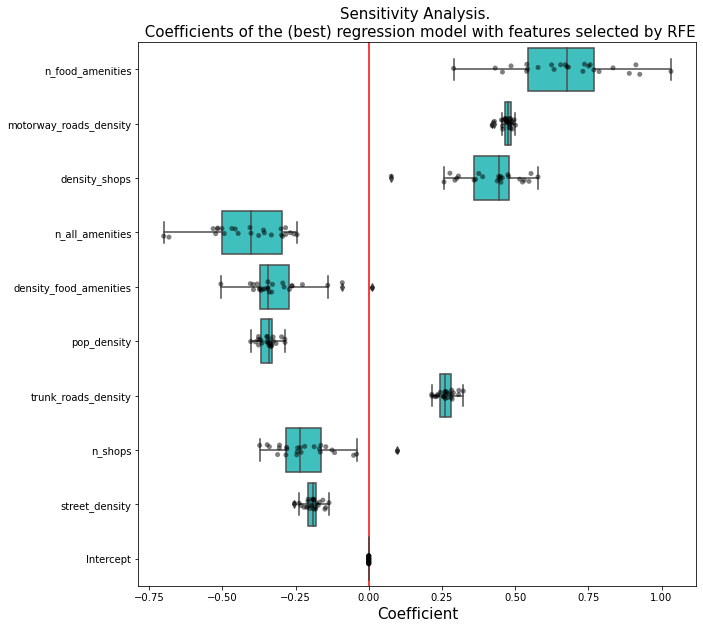

In [60]:
X_rfe = X.iloc[:, cols_rfe]

pipe_best = Pipeline(steps=[
    ("preprocessor", preprocessor), 
    ("regressor", LinearRegression())
])

model_best = TransformedTargetRegressor(
    regressor=pipe_best, transformer=PowerTransformer()
)

model_best.fit(X_rfe, y)


## CV
cv_rfe = cross_validate(
    model_best,
    X_rfe,
    y,
    cv=RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE),
    scoring=["neg_root_mean_squared_error"],
    return_estimator=True,
    n_jobs=-1,
)

coefs_rfe = pd.DataFrame(
    [est.regressor_.named_steps["regressor"].coef_ for est in cv_rfe["estimator"]],
    columns=X_rfe.columns,
)

coefs_rfe["Intercept"] = pd.Series(
    [est.regressor_.named_steps["regressor"].intercept_ for est in cv_rfe["estimator"]]
)

medians_rfe = coefs_rfe.drop(["Intercept"], axis=1).median()
medians_rfe = medians_rfe.reindex(medians_rfe.abs().sort_values(ascending=False).index)
medians_rfe = medians_rfe.append(pd.Series({"Intercept": 0}, index=["Intercept"]))
coefs_rfe = coefs_rfe[medians_rfe.index]

limit_value = (
    max(abs(coefs_rfe.to_numpy().min()), abs(coefs_rfe.to_numpy().max())) * 1.05
)


## plotting
fig, ax = plt.subplots(figsize=(10, 10))

sns.stripplot(ax=ax, data=coefs_rfe, orient="h", color="k", alpha=0.5)
sns.boxplot(ax=ax, data=coefs_rfe, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color="red")
plt.title(f"Sensitivity Analysis. \n Coefficients of the (best) regression model with features selected by RFE", fontsize=15)
#ax.set_xlim(-limit_value, limit_value)
ax.set_xlabel("Coefficient", fontsize=15)

plt.show()

## Ridge regression

In [49]:
from sklearn.linear_model import RidgeCV

# Define a pipeline with the preprocessing, feature selection (RFE) and regressor

#preprocessor = Pipeline(steps=[("pt", PowerTransformer(standardize=True))])
preprocessor = Pipeline(steps=[("ss", StandardScaler())])

n_alphas = 100
alphas = np.logspace(-3, 10, n_alphas)

pipe_rfe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("rfe", RFE(estimator=RidgeCV(alphas=alphas))),
        ("regressor", RidgeCV(alphas=alphas)),
    ]
)

# Define the param space for hyper-parameter tunning (in this case, the number of features to keep with RFE)
param_grid_rfe = [{"rfe__n_features_to_select": np.arange(1, len(all_predictors)+1, 1)}] # try with all the possible number of features

search_rfe = GridSearchCV(
    pipe_rfe, param_grid_rfe, scoring="neg_root_mean_squared_error", n_jobs=-1
)

model = TransformedTargetRegressor(regressor=search_rfe, transformer=PowerTransformer())
model.fit(X, y)


print("Best Model:")
print(
    "Number of features: "
    + str(model.regressor_.best_params_["rfe__n_features_to_select"])
)
print("\nList of features:")
cols_rfe = model.regressor_.best_estimator_.named_steps["rfe"].get_support(indices=True)
print(X.columns[cols_rfe])

Best Model:
Number of features: 10

List of features:
Index(['density_traffic_lights', 'street_density', 'motorway_roads_density',
       'trunk_roads_density', 'primary_roads_density', 'density_all_amenities',
       'perc_roads_bc', 'car_accidents',
       'perc_people_close_to_public_transport', 'pop_density'],
      dtype='object')


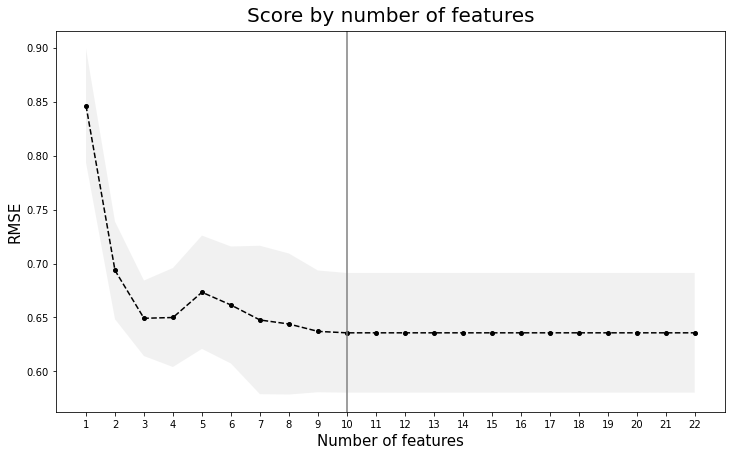

In [50]:
score_features = -model.regressor_.cv_results_["mean_test_score"]
score_std_features = model.regressor_.cv_results_["std_test_score"]
n_features = []
for i in model.regressor_.cv_results_["params"]:
    n_features.append(i["rfe__n_features_to_select"])

id_min_score = score_features.argmin()

fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(n_features, score_features, marker=".", markersize=8, color='black', linestyle='--')
plt.axvline(x=n_features[id_min_score], color=".5")

ax.fill_between(n_features, score_features+score_std_features, score_features-score_std_features, 
                    alpha=0.3, facecolor='lightgrey')

ax.set_xlabel("Number of features", fontsize=15)
ax.set_ylabel("RMSE", fontsize=15)
ax.set_xticks(np.arange(min(n_features), max(n_features) + 1))
ax.set_title("Score by number of features", fontsize=20, y=1.01)

plt.show()

> regression results <
Mean squared error: 0.35
Root mean squared error: 0.59
Median absolute error: 0.45
Coefficient of determination: 0.65



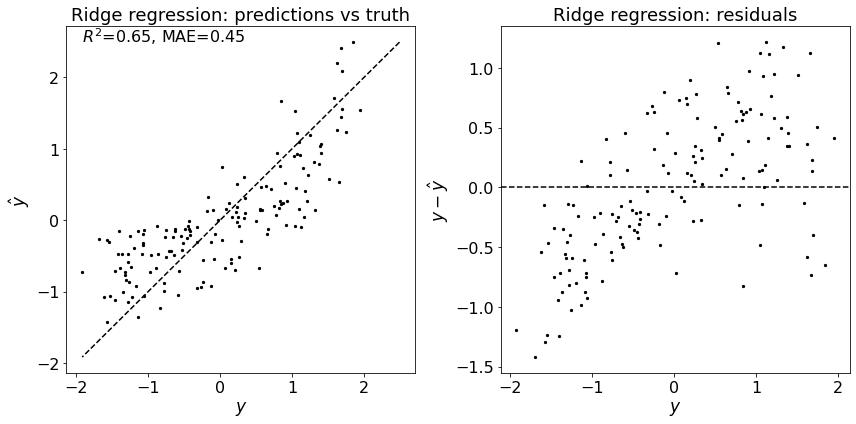

In [51]:
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

y_pred_rfe = model.predict(X)#.round()
res = [y.iloc[i]-y_pred_rfe[i] for i in range(len(y))]
#normaltest_shapiro(res, verbose=True)

pwt = PowerTransformer()
pwt.fit(y.values.reshape(-1, 1))

####################Tranform y_hat####################
#y_pred_transformed = model.predict(X)
y_pred_transformed = pwt.transform(y_pred_rfe.reshape(-1, 1)).flatten()

####################Trasform y####################
y_transformed = pd.Series(pwt.transform(y.values.reshape(-1, 1)).flatten())
y_transformed.name = "Transformed avg CO2 per road"


res_transformed = [y_transformed.iloc[i]-y_pred_transformed[i] for i in range(len(y_transformed))]

print('> regression results <')
#print("Coefficients: \n", model.coef_)
#print("Intercept: ", model.intercept_)
mse = mean_squared_error(y_transformed, y_pred_transformed)
rmse = mean_squared_error(y_transformed, y_pred_transformed, squared=False)
mae = median_absolute_error(y_transformed, y_pred_transformed)
r2 = r2_score(y_transformed, y_pred_transformed)
print("Mean squared error: %.2f" % mse)
print("Root mean squared error: %.2f" % rmse)
print("Median absolute error: %.2f" % mae)
print("Coefficient of determination: %.2f" % r2)
print('')

# plotting the results
f, axs = plt.subplots(1, 2, figsize=(12,6))
axs[0].scatter(y_transformed, y_pred_transformed, color='black', s=5)
p1 = max(max(y_pred_transformed), max(y_transformed))
p2 = min(min(y_pred_transformed), min(y_transformed))
axs[0].plot([p1, p2], [p1, p2], '--k')
axs[0].set_ylabel(r'$\hat{y}$', fontsize=17)
axs[0].set_xlabel(r'$y$', fontsize=17)
axs[0].tick_params(axis='both', which='major', labelsize=16)
axs[0].set_title('Ridge regression: predictions vs truth', fontsize=18)
axs[0].text(p2, max(y_pred_transformed), r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_transformed, y_pred_transformed), median_absolute_error(y_transformed, y_pred_transformed)),
    fontdict={'size':16})
axs[1].scatter(y_transformed, res_transformed, color='black', s=5)
axs[1].axhline(0, linestyle='--', color='black')
axs[1].set_ylabel(r'$y-\hat{y}$', fontsize=17)
axs[1].set_xlabel(r'$y$', fontsize=17)
axs[1].tick_params(axis='both', which='major', labelsize=16)
axs[1].set_title('Ridge regression: residuals', fontsize=18)
plt.tight_layout()

# Watermark

In [43]:
%load_ext watermark
%watermark

Last updated: 2022-05-11T11:48:16.142199+02:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 8.2.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 5.14.0-1034-oem
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



In [44]:
%watermark --iversions

seaborn   : 0.11.2
numpy     : 1.21.6
geopandas : 0.10.0
matplotlib: 3.5.1
pandas    : 1.4.2

